In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
import numpy as np

In [2]:
df = pd.read_csv('ChickWeight.csv')

In [3]:
df.shape

(578, 5)

In [4]:
df.head()

,Unnamed: 0,weight,Time,Chick,Diet
0,1,42,0,1,1
1,2,51,2,1,1
2,3,59,4,1,1
3,4,64,6,1,1
4,5,76,8,1,1


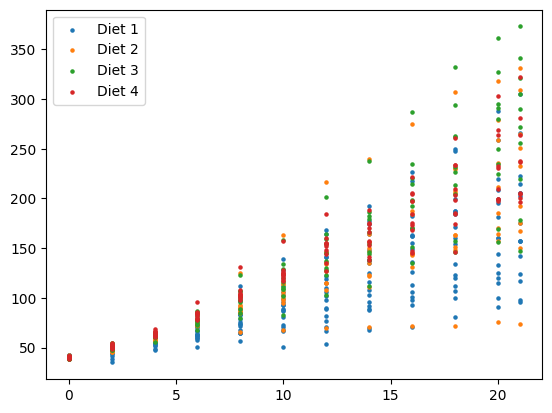

In [5]:
for diet, group in df.groupby('Diet'):
    plt.scatter(group.Time, group.weight, s=5, label=f'Diet {diet}')
plt.legend()
plt.show()

In [6]:
df.groupby('Chick')['Diet'].nunique().max().item()

1

In [7]:
class OnlyEmbeddingLinearRegressionWithIntercept(nn.Module):
    def __init__(self, num_categories):
        super().__init__()
        self.slope_embedding = nn.Embedding(num_embeddings=num_categories + 1, embedding_dim=2)  # Learnable slope per category
        self.bias = nn.Parameter(torch.tensor([0.0]))  # Shared bias for all categories

    def forward(self, x, category):
        slopes = self.slope_embedding(category)  # Retrieve slope for category
        x = x.squeeze(-1)
        x = torch.stack([x ** 2.0, x], dim=1)
        return (x * slopes).sum(dim=1) + self.bias  # Apply learned bias

In [8]:
num_categories = 4
model = OnlyEmbeddingLinearRegressionWithIntercept(num_categories)

In [9]:
x = torch.Tensor(df.Time).unsqueeze(-1)
diet = torch.LongTensor(df.Diet)
weight = torch.Tensor(df.weight)

In [10]:
out = model(x, diet)

In [11]:
F.mse_loss(out, weight)

tensor(30992.2500, grad_fn=<MseLossBackward0>)

In [12]:
opt = optim.SGD(params=model.parameters(), lr=1e-7)

In [13]:
for epoch in range(1, 2000 + 1):
    opt.zero_grad()
    out = model(x, diet)
    loss = F.mse_loss(out, weight)
    loss.backward()
    opt.step()
    if epoch % 50 == 0:
        print(f'{epoch} loss={loss}')

50 loss=25826.794921875
100 loss=21546.38671875
150 loss=18076.52734375
200 loss=15262.7685546875
250 loss=12980.365234375
300 loss=11128.486328125
350 loss=9625.572265625
400 loss=8405.625
450 loss=7415.1826171875
500 loss=6610.9453125
550 loss=5957.81396484375
600 loss=5427.330078125
650 loss=4996.41455078125
700 loss=4646.34130859375
750 loss=4361.91748046875
800 loss=4130.8115234375
850 loss=3943.012939453125
900 loss=3790.392822265625
950 loss=3666.350830078125
1000 loss=3565.52734375
1050 loss=3483.569091796875
1100 loss=3416.940673828125
1150 loss=3362.768310546875
1200 loss=3318.71630859375
1250 loss=3282.892333984375
1300 loss=3253.7529296875
1350 loss=3230.04736328125
1400 loss=3210.756591796875
1450 loss=3195.055419921875
1500 loss=3182.271240234375
1550 loss=3171.85888671875
1600 loss=3163.3740234375
1650 loss=3156.455322265625
1700 loss=3150.81005859375
1750 loss=3146.200439453125
1800 loss=3142.432861328125
1850 loss=3139.34912109375
1900 loss=3136.8212890625
1950 loss=31

In [14]:
bias = model.bias.item()

In [15]:
slopes = model.slope_embedding(torch.LongTensor(range(1, 5))).squeeze(-1).detach().tolist()

In [16]:
bias, slopes

(0.015953203663229942,
 [[0.5925264954566956, -1.7555841207504272],
  [0.6259406208992004, -1.250399112701416],
  [0.784480094909668, -1.2498327493667603],
  [0.6813876032829285, -0.6769828200340271]])

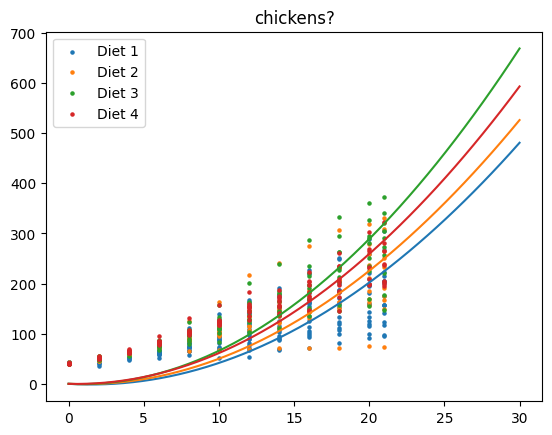

In [17]:
lin_sp = np.linspace(0, 30)
xs = np.stack([lin_sp ** 2, lin_sp], axis=0)

for diet, group in df.groupby('Diet'):
    plt.scatter(group.Time, group.weight, s=5, label=f'Diet {diet}')
    b, s = bias, slopes[diet - 1]
    plt.plot(lin_sp, s @ xs + b) 
plt.legend()
plt.title('chickens?')
plt.show()